In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import pandas as pd
from src.data import *
from src.portfolio import *
from src.efficient_frontier import *
from src.plot import *
import yfinance as yf
from scipy.optimize import Bounds, LinearConstraint
from pypfopt.expected_returns import mean_historical_return

In [33]:
esg_data = esg_score_weight(pd.read_excel('data/ESG_DATA.xlsx'), np.array([1/3,1/3,1/3]), 400.0)
full_data = stock_monthly_close(esg_data, dates=('2003-01-01','2023-01-01'))
prices, esg = seperate_full_data(full_data)
#prices = currency_rates(prices)
#prices = pd.read_csv('data/PRICES.csv')

In [34]:
esg_data

,Isin,CurrencyCode,company_name,environment_grade,environment_level,environment_score,governance_grade,governance_level,governance_score,social_grade,social_level,social_score,stock_symbol,total,total_grade,total_level,weighted_score
0,SE0011337708,SEK,AAK AB (publ.),AA,Excellent,647,BB,Medium,345,BB,Medium,307,AAK.ST,1299,A,High,433.000000
21,SE0000862997,SEK,BillerudKorsnäs AB (publ),A,High,550,BB,Medium,345,BB,Medium,305,BILL.ST,1200,A,High,400.000000
45,SE0005468717,SEK,Fnm.,A,High,566,BB,Medium,335,BB,Medium,362,FNM.ST,1263,A,High,421.000000
127,NO0010307135,NOK,Abbott Laboratories,A,High,520,BB,Medium,354,BB,Medium,355,ABT.OL,1229,A,High,409.666667
155,NO0011002586,NOK,Elmo Software Limited,A,High,560,BB,Medium,340,BB,Medium,304,ELO.OL,1204,A,High,401.333333
191,NO0010629108,NOK,NextSource Materials Inc.,AA,Excellent,600,BB,Medium,315,BB,Medium,327,NEXT.OL,1242,A,High,414.000000
210,NO0010840507,NOK,Pexip Holding ASA,A,High,570,BB,Medium,340,BB,Medium,303,PEXIP.OL,1213,A,High,404.333333
230,KYG236271055,NOK,"Shelf Drilling, Ltd.",A,High,595,BB,Medium,380,BB,Medium,303,SHLF.OL,1278,A,High,426.000000
243,NO0010708068,NOK,VOW ASA,A,High,575,BB,Medium,338,BB,Medium,364,VOW.OL,1277,A,High,425.666667
252,DK0010263722,DKK,AGF Management Limited,AA,Excellent,700,BB,Medium,350,BB,Medium,373,AGF-B.CO,1423,A,High,474.333333


In [21]:
prices = filter_prices(prices, 0, 10)
returns_pct_change = pct_returns_from_prices(prices)

In [22]:
rolling_window_expected_return(returns_pct_change)

,ABB.ST,ADDT-B.ST,ALFA.ST,ATRLJ-B.ST,AXFO.ST,AZA.ST,AZN.ST,BALD-B.ST,BILL.ST,BINV.ST
2013-01-01,0.243898,0.241772,0.267213,0.204185,0.074351,0.306726,0.022921,0.215893,0.124915,0.025024
2014-01-01,0.165201,0.249201,0.215422,0.183969,0.082331,0.253804,0.032610,0.212273,0.125615,0.036132
2015-01-01,0.172020,0.232561,0.208630,0.178944,0.121589,0.240725,0.099386,0.283921,0.169342,0.042031
2016-01-01,0.086824,0.180402,0.164978,0.145927,0.130839,0.175572,0.058146,0.323831,0.189244,0.016269
2017-01-01,0.079256,0.164325,0.102611,0.085141,0.103073,0.175575,0.038564,0.292019,0.181011,-0.025663
2018-01-01,0.058048,0.205358,0.117720,0.119800,0.119094,0.192971,0.096002,0.347008,0.229053,-0.071947
2019-01-01,0.064255,0.235233,0.147346,0.119994,0.156754,0.215847,0.093541,0.416139,0.327213,-0.063083
2020-01-01,0.068519,0.246279,0.109887,0.140874,0.148102,0.146763,0.121436,0.380974,0.145762,-0.124210
2021-01-01,0.067064,0.242704,0.073306,0.086988,0.141281,0.215248,0.123082,0.300821,0.139075,-0.083069
2022-01-01,0.100090,0.301754,0.110628,0.116094,0.153272,0.275072,0.142547,0.334539,0.143905,-0.070752


In [23]:
parameters = rolling_window_efficient_frontier(returns_pct_change)

c:\Users\toros\OneDrive\Dokumenter\GitHub\BachelorThesis\src\efficient_frontier.py:39: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,
c:\Users\toros\OneDrive\Dokumenter\GitHub\BachelorThesis\src\efficient_frontier.py:55: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,


Min. Risk = 11.687% => Return: 7.575%  Sharpe Ratio = 0.65
Max. Sharpe Ratio = 1.23 => Return: 27.40%  Risk: 22.225%
Min. Risk = 11.618% => Return: 8.412%  Sharpe Ratio = 0.72
Max. Sharpe Ratio = 1.12 => Return: 20.02%  Risk: 17.927%
Min. Risk = 12.170% => Return: 12.428%  Sharpe Ratio = 1.02
Max. Sharpe Ratio = 1.21 => Return: 17.32%  Risk: 14.370%
Min. Risk = 12.427% => Return: 8.242%  Sharpe Ratio = 0.66
Max. Sharpe Ratio = 1.11 => Return: 23.05%  Risk: 20.777%
Min. Risk = 12.616% => Return: 6.279%  Sharpe Ratio = 0.50
Max. Sharpe Ratio = 1.01 => Return: 25.84%  Risk: 25.566%
Min. Risk = 12.670% => Return: 9.484%  Sharpe Ratio = 0.75
Max. Sharpe Ratio = 1.35 => Return: 30.99%  Risk: 22.899%
Min. Risk = 11.247% => Return: 9.145%  Sharpe Ratio = 0.81
Max. Sharpe Ratio = 1.77 => Return: 43.32%  Risk: 24.488%
Min. Risk = 11.478% => Return: 9.905%  Sharpe Ratio = 0.86
Max. Sharpe Ratio = 1.90 => Return: 47.72%  Risk: 25.179%
Min. Risk = 12.266% => Return: 9.998%  Sharpe Ratio = 0.82
Max.

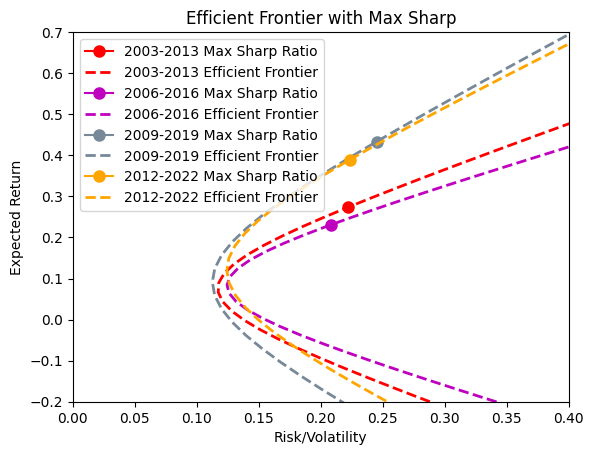

In [24]:
plot_efficient_frontier(parameters)

In [25]:
parameters = []
for i in range(0, 11):
  #r_opt_set = set()
  print(f"-------------------------- 20{3+i:02d}-20{13+i:02d} --------------------------")

  # define the rolling window
  sample_rolling_window = returns_pct_change[i*12:i*12+(12*10)]

  ret_port = mean_return_annual(sample_rolling_window)

  cov_port = covariance_matrix_annual(sample_rolling_window)

  parameters.append(calculate_efficient_frontier(ret_port, cov_port))


-------------------------- 2003-2013 --------------------------
Min. Risk = 11.687% => Return: 7.575%  Sharpe Ratio = 0.65
Max. Sharpe Ratio = 1.23 => Return: 27.40%  Risk: 22.225%


c:\Users\toros\OneDrive\Dokumenter\GitHub\BachelorThesis\src\efficient_frontier.py:39: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,
c:\Users\toros\OneDrive\Dokumenter\GitHub\BachelorThesis\src\efficient_frontier.py:55: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,


-------------------------- 2004-2014 --------------------------
Min. Risk = 11.618% => Return: 8.412%  Sharpe Ratio = 0.72
Max. Sharpe Ratio = 1.12 => Return: 20.02%  Risk: 17.927%
-------------------------- 2005-2015 --------------------------
Min. Risk = 12.170% => Return: 12.428%  Sharpe Ratio = 1.02
Max. Sharpe Ratio = 1.21 => Return: 17.32%  Risk: 14.370%
-------------------------- 2006-2016 --------------------------
Min. Risk = 12.427% => Return: 8.242%  Sharpe Ratio = 0.66
Max. Sharpe Ratio = 1.11 => Return: 23.05%  Risk: 20.777%
-------------------------- 2007-2017 --------------------------
Min. Risk = 12.616% => Return: 6.279%  Sharpe Ratio = 0.50
Max. Sharpe Ratio = 1.01 => Return: 25.84%  Risk: 25.566%
-------------------------- 2008-2018 --------------------------
Min. Risk = 12.670% => Return: 9.484%  Sharpe Ratio = 0.75
Max. Sharpe Ratio = 1.35 => Return: 30.99%  Risk: 22.899%
-------------------------- 2009-2019 --------------------------
Min. Risk = 11.247% => Return:

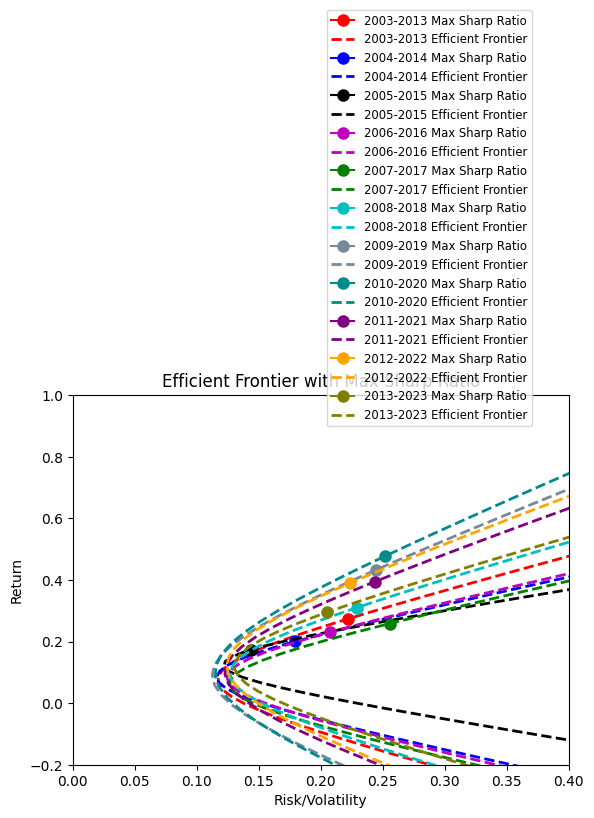

In [26]:
#mpl.style.use('classic')
mpl.style.use('default')

fig, ax = plt.subplots()
plt.title('Efficient Frontier with Max Sharp Ratio', fontsize=12)
plt.xlabel('Risk/Volatility')
plt.ylabel('Return')
colors = ['r','b','k','m','g','c', 'lightslategrey', "darkcyan", "purple", "orange", "olive"]
for i, x in enumerate(parameters):
  opt_sr_vol, opt_sr_ret, opt_risk_vol,  opt_risk_ret, frontier_x, frontier_y, _ = x
  #ax.plot(opt_sr_vol, opt_sr_ret,'*', markersize=20, label=f'20{3+i:02d}-20{13+i:02d} Max Sharpe') # red star
  plt.plot(opt_sr_vol,  opt_sr_ret, marker='o', color = f'{colors[i]}', markersize=8, label=f'20{3+i:02d}-20{13+i:02d} Max Sharp Ratio') # red dot
  plt.plot(frontier_x, frontier_y, linestyle='--', color = f'{colors[i]}', linewidth=2, label=f'20{3+i:02d}-20{13+i:02d} Efficient Frontier') # red dashed line
  
  #ax.scatter(x[2], x[1], marker="*", s=100, label=f"20{3+i:02d}-20{13+i:02d} Max Sharpe")
plt.xlim([0.0,0.4])
plt.ylim([-0.2,1])
plt.legend(bbox_to_anchor =(0.5, 0.9, 1, 0), ncol = 1, fontsize="small")
#fig_path = os.path.join(PLOTS_PATH, f"efficient_frontier.png")
#plt.savefig(fig_path, dpi=150,bbox_inches="tight")
plt.show()

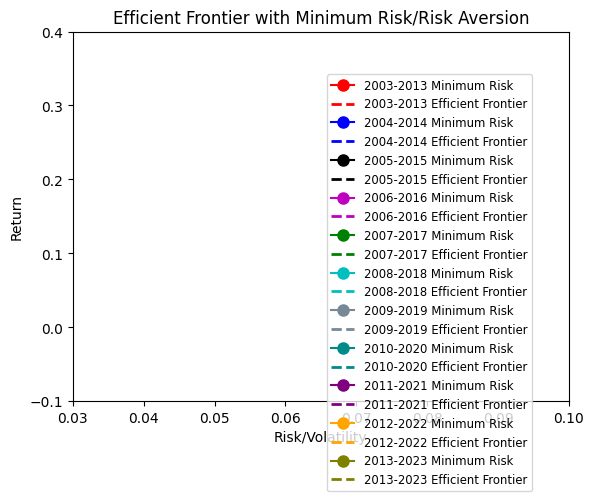

In [27]:
#mpl.style.use('classic')
mpl.style.use('default')

fig, ax = plt.subplots()
plt.title('Efficient Frontier with Minimum Risk/Risk Aversion', fontsize=12)
plt.xlabel('Risk/Volatility')
plt.ylabel('Return')
colors = ['r','b','k','m','g','c', 'lightslategrey', "darkcyan", "purple", "orange", "olive"]
for i, x in enumerate(parameters):
  opt_sr_vol, opt_sr_ret, opt_risk_vol,  opt_risk_ret, frontier_x, frontier_y, _ = x
  #ax.plot(opt_sr_vol, opt_sr_ret,'*', markersize=20, label=f'20{3+i:02d}-20{13+i:02d} Max Sharpe') # red star
  plt.plot(opt_risk_vol,  opt_risk_ret, marker='o', color = f'{colors[i]}', markersize=8, label=f'20{3+i:02d}-20{13+i:02d} Minimum Risk') # red dot
  plt.plot(frontier_x, frontier_y, linestyle='--', color = f'{colors[i]}', linewidth=2, label=f'20{3+i:02d}-20{13+i:02d} Efficient Frontier') # red dashed line
  
  #ax.scatter(x[2], x[1], marker="*", s=100, label=f"20{3+i:02d}-20{13+i:02d} Max Sharpe")
plt.xlim([0.03,0.1])
plt.ylim([-0.1,0.4])
plt.legend(bbox_to_anchor =(0.5, 0.9, 1, 0), ncol = 1, fontsize="small")
#fig_path = os.path.join(PLOTS_PATH, f"efficient_frontier.png")
#plt.savefig(fig_path, dpi=150,bbox_inches="tight")
plt.show()

In [28]:
portfolio_mean(df)

NameError: name 'df' is not defined

In [ ]:
cov = portfolio_covariance(df)
portfolio_std(cov, w)

In [ ]:
portfolio_sharp_ratio(df, w, cov)

In [ ]:
#bounds = Bounds(-2, 5)

#Create x0, the first guess at the values of each asset's weight.
#w0 = np.linspace(start=1, stop=0, num=cov.shape[1])
#x0 = w0/np.sum(w0)
# All weights between 0 and 1
# # The second boundary is the sum of weights.
#linear_constraint = LinearConstraint(np.ones((cov.shape[1],), dtype=int),1,1)
#options = {'xtol': 1e-07, 'gtol': 1e-07, 'barrier_tol': 1e-07, 'maxiter': 1000}
 

In [ ]:
def portfolio_minimize_risk(port_return, 
                                port_covariance, 
                                esg_data, 
                                x0,
                                linear_constraint, 
                                bounds, 
                                options = None):
    """
    Function that will take different inputs including esg score data and compute the minimum risk of different portfolios 
    :param: A dataframe of the portfolio covariance matrix
    :param: A dataframe of esg scores of the different assets in portfolio
    :param: x0 argument that is the initial guess for the minimizer
    :param: Linear constraints for the minimizer
    :param: Bounds for the minimizer
    :param: 
    :param: Options for the minimizer
    :returns: A dataframe containing portfolio weight choice for minimizing portfolio risk using esg scores
    """
    
    results = {'esg':[],
               'weights':[],
               'risk':[],
               'return':[]}
    
    function = lambda weight: portfolio_std(port_cov=port_covariance, weights=weight)
    constraint_esg = {'type': 'eq', 'fun': lambda weight: np.dot(weight, esg_data)}
    result = minimize(function, 
                      x0, 
                      method='trust-constr', 
                      bounds=bounds, 
                      constraints=[linear_constraint, constraint_esg], 
                      options=options)
   
    optimal_weights = list(result['x'])
    print(optimal_weights)
    optimal_esg = np.dot(optimal_weights, esg_data)
    results['esg'].append(optimal_esg)
    results['weights'].append(optimal_weights)
    results['risk'].append(result['fun'])
    results['return'].append(np.dot(optimal_weights, port_return.sum()))

    return results


In [ ]:
# set the window size
#window_size = 2

# make different lists to append data in every window
#expected_return = []
#expected_year = []

#def simple_return(beginning_price, end_price):
#  return ((end_price-beginning_price)/beginning_price)

#def annual_return(simple_return, years_held):
#  return (((simple_return+1)**(1/years_held))-1)

# setup af loop to iterate through window and make calculations
#for i in range(0, 6):

  # define the rolling window
#  sample_rolling_window = df[i*12:i*12+(12*window_size)]

  # calculate the expected return as a dataframe
#  window_monthly_returns = pd.DataFrame()
#  window_monthly_returns = sample_rolling_window
#  simple_window_yearly_returns_mean = simple_return(window_monthly_returns.iloc[0], window_monthly_returns.iloc[-1])
#  annual_window_return = annual_return(simple_window_yearly_returns_mean, window_size)

  # append the results of expected return and the years to list
#  expected_return.append(annual_window_return)

# make list of expected return into a dataframe
#for x in range(2013, 2024):
#  expected_year.append(dt(x,1,1))
  
#expected_return = pd.DataFrame(expected_return, index=expected_year)

#expected_return


In [ ]:
#esg_data = pd.read_excel('ESG_DATA.XLS')
#for index, row in esg_data.iterrows():
    # stockholm exchange
    if row['Isin'].startswith('SE'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.ST'
    
    # swiss exchange
    elif row['Isin'].startswith('CH0242214887'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.ST'
    elif row['Isin'].startswith('CH1122548808'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('CH'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.SW'
    
    # toroto exchange
    elif row['Isin'].startswith('CA98936C1068'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.L'
    elif row['Isin'].startswith('CA'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.TO'
    elif row['Isin'].startswith('GB'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.L'
    
    # paris exchange
    elif row['Isin'].startswith('FR'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.PA'

    # copenhagen exchange
    
    elif row['Isin'].startswith('DK0060668796'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.ST'
    elif row['Isin'].startswith('DK0060520450'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('FI4000297767'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.CO' 
    elif row['Isin'].startswith('DK'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.CO'

    # oslo exchange
    elif row['Isin'].startswith('NO'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('KYG'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL' 
    elif row['Isin'].startswith('CY'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('BMG'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('MHY'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.SG'
    elif row['Isin'].startswith('US36467X2062'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('SGX'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('FO0000000179'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'

    elif row['Isin'].startswith('MT0000580101'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.DE'
    elif row['Isin'].startswith('MT0001390104'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.ST'
    elif row['Isin'].startswith('MT'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.SG'
   